# EKS with distance constraints

In [204]:
import os
import numpy as np
import pandas as pd
import sys
from eks.utils import *
from eks.multiview_pca_fish import *
from eks.multiview_pca_smoother import pca, ensemble_kalman_smoother_multi_cam
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm


In [205]:
camera_names = ['main', 'top', 'right']
keypoint_ensemble_list = ['mid','fork','chin_base']
tracker_name = 'heatmap_mhcrnn_tracker'
num_cameras = len(camera_names)
labeled_data = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/mirror-fish/CollectedData_new.csv", header = [1,2])

#%% set distance constraint projection for a few q's in keypoint_ensemble_list


camkeys = ["_main","_top","_right"]
# flatten columns
labeled_data.columns = ['_'.join(tup).rstrip('_') for tup in labeled_data.columns.values]
mask = []
for keys in keypoint_ensemble_list:
    for cam in camkeys:
        for coord in ["_x", "_y"]:
            mask.append(keys+cam+coord)
            

In [206]:
labeled_data.head()

,bodyparts_coords,head_main_x,head_main_y,chin_base_main_x,chin_base_main_y,chin1_4_main_x,chin1_4_main_y,chin_half_main_x,chin_half_main_y,chin3_4_main_x,...,tail_neck_right_x,tail_neck_right_y,dorsal_right_x,dorsal_right_y,anal_right_x,anal_right_y,caudal_d_right_x,caudal_d_right_y,caudal_v_right_x,caudal_v_right_y
0,labeled-data/20210126_Sean/img001058.png,284.0,324.5,292.5,353.5,292.0,356.5,290.0,358.5,286.5,...,429.5,255.5,413.5,250.5,426.0,289.0,441.5,227.0,442.5,246.0
1,labeled-data/20210126_Sean/img001503.png,304.5,322.0,304.5,349.5,304.0,354.0,303.0,357.5,303.0,...,445.0,276.5,431.0,267.0,448.0,310.0,437.0,242.5,439.0,257.5
2,labeled-data/20210126_Sean/img014428.png,290.5,328.5,285.0,362.0,284.5,366.0,289.0,366.5,293.0,...,413.5,259.5,387.5,258.0,434.0,284.5,418.5,224.5,430.5,244.5
3,labeled-data/20210126_Sean/img015407.png,418.5,347.0,453.5,364.5,455.5,367.5,458.5,372.0,460.5,...,426.0,327.0,440.5,307.5,NaN,NaN,421.0,310.0,NaN,NaN
4,labeled-data/20210126_Sean/img019268.png,319.0,325.5,302.0,340.0,301.5,343.5,301.5,347.0,303.0,...,472.0,288.5,449.5,269.5,462.5,324.0,NaN,NaN,NaN,NaN


In [207]:
img197707_id = labeled_data.loc[['labeled-data/20210204_Quin/img197707.png' in s for s in labeled_data.bodyparts_coords]].index[0]

## 3D projection minimising limb distance variance

In [245]:
markers_list = labeled_data.reset_index()[mask]
# Ensemble
scaled_dict = []
good_frames_dict = []
good_preds_dict = []
ensemble_vars_dict = []
means_camera_dict = []
markers_list_cameras  = []
            
n = len(markers_list)
nkeys = len(keypoint_ensemble_list)
num_cameras = len(camkeys)
y_obs = np.empty((nkeys, n, 2*num_cameras))
q = np.empty((nkeys, n, 3))
for j, keypoint_ensemble in enumerate(keypoint_ensemble_list):
    markers_list_cameras = [[] for i in range(num_cameras)]
    for i,cam in enumerate(camkeys):
        tmp = []

        for m in markers_list.keys():
            if cam in m and keypoint_ensemble in m:
                tmp.append(markers_list[m])
    
        markers_list_cameras[i].append(pd.concat(tmp, axis=1))

    
    y = np.asarray(markers_list_cameras).reshape(n, nkeys*2)
    
    # fill nans by median value 
    col_mean = np.nanmedian(y, axis=0)
    inds = np.where(np.isnan(y))
    y[inds] = np.take(col_mean, inds[1])
    
    # scale 
    from sklearn.preprocessing import scale
    scaled_y = scale(y)
    # get PCA 
    labeled_pca, labeled_var = pca(y, 3)
    
    q[j,:,:] = labeled_pca.transform(scaled_y)
    y_obs[j,:,:] = y


In [254]:
np.var(q,axis=0).shape

(94, 3)

In [260]:
v = np.zeros(q.shape[1])
for t in range(q.shape[1]):
    for i in range(q.shape[0]):
        for j in range(q.shape[0]):
            if j!= i:
                 v[t] = np.var(np.linalg.norm(L@(q[i,t,:]-q[j,t,:]).T,axis=0))

In [264]:
np.

93

In [289]:
v = np.zeros((q.shape[0],q.shape[0],q.shape[1]))
Lv = v
for t in range(q.shape[1]):
    for i in range(q.shape[0]):
        for j in range(q.shape[0]):
            if j!= i:
                #print('one',np.linalg.norm(q[i,t,:]-q[j,t,:]))
                v[i,j,t] = np.linalg.norm(q[i,t,:]-q[j,t,:])
                Lv[i,j,t]= np.linalg.norm(L@q[i,t,:]-L@q[j,t,:])

In [292]:
test = np.var(v,axis=0)
testL = np.var(Lv,axis=0)

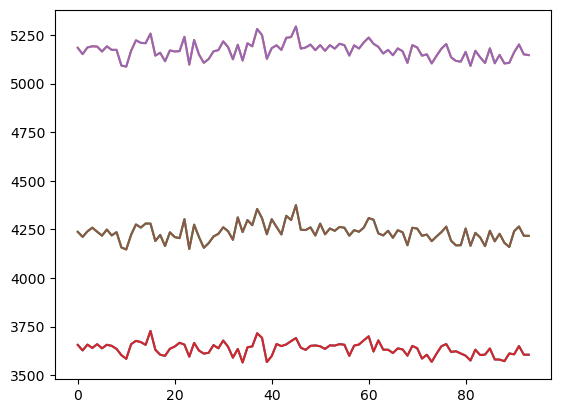

In [293]:
plt.plot(test.T)
plt.plot(testL.T)

In [209]:
c = [('fork', 'mid'), ('chin_base', 'fork'), ('mid', 'chin_base')]

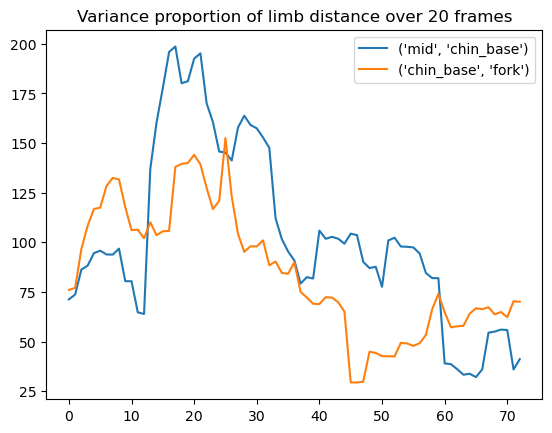

In [210]:
# Initialize L as a lower triangular matrix
n = 3  # Define the size of L
L_initial = np.tril(np.eye(n)).flatten()
import plotly.io as pio
import plotly.express as px
pio.renderers.default='browser'

L = find_linear_transformation(q, L_initial)

v = variance_limb_plot(20, L, q, pair_list, keypoint_ensemble_list)

D = get_3d_distance_loss(q, L, keypoint_ensemble_list,c, 3)




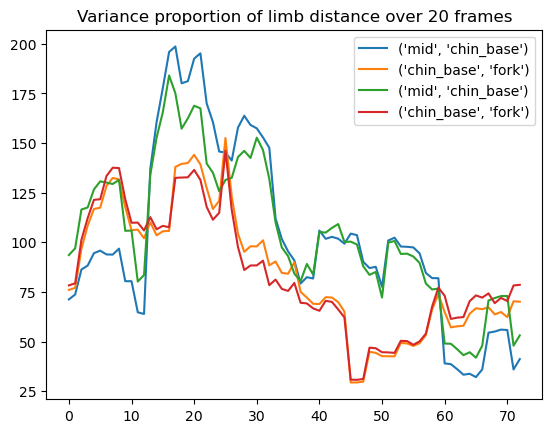

In [235]:
v = variance_limb_plot(20, L, q, pair_list, keypoint_ensemble_list)
v = variance_limb_plot(20, np.eye(3), q, pair_list, keypoint_ensemble_list)



In [211]:
D_ij = D[img197707_id,:,:]
D_ij

array([[   0.        , 1169.55609448, 1668.35033174],
       [1169.55609448,    0.        ,  498.79481527],
       [1668.35033174,  498.79481527,    0.        ]])

In [216]:
ensemble_pcs.shape

(3, 51, 3)

In [224]:
colors=['r','b','g']
for i in range(3):
    plt.plot(ensemble_pcs[i,:,:], color=colors[i], '-')
    plt.plot(ensemble_pcs[i,:,:]@L, color=colors[i, '-')

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (3619267276.py, line 4)

In [226]:
mu = [0,0.01,0.1, 0.2, 0.5, 0.10]
c = [('fork','mid'),('chin_base','fork'),('mid','chin_base')]
folder = "/eks_opti"
operator = "/20210204_Quin/"
name = "img197707"

baseline = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/eks"+operator+name+".csv", header=[ 1, 2],index_col=0)
#new = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/one-video-mirror-fish-predictions"+folder+operator+name, header=[ 1, 2], index_col=0)
baseline0 = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/eks"+operator+name+".csv", header=[0, 1, 2],index_col=0)


# NOTE! replace this path with an absolute path where you want to save EKS outputs
eks_save_dir = '/Users/clairehe/Documents/GitHub/eks/data/misc/one-video-mirror-fish-predictions/eks_opti/'

# path for prediction csvs
file_path = '/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions'

# NOTE! replace these paths with the absolute paths to prediction csvs on your local computer
model_dirs = [
    file_path+"/network_0",
    file_path+"/network_1",
    file_path+"/network_2",
    file_path+"/network_3",
    file_path+"/network_4",
]


#    'head', 'chin_base', 'chin1_4', 'chin_half','chin3_4', 'chin_tip', 'mid', 'fork',
#   'stripeA', 'stripeP', 'tail_neck', 'dorsal', 'anal', 'caudal_d', 'caudal_v',

#image_path = "/Users/clairehe/Documents/GitHub/eks/data/mirror-fish/labeled-data"
#im = plt.imread(image_path+operator+name+".png")
#plt.imshow(im)
#plt.suptitle("labeled "+name)


session = '20210204_Quin'
frame = 'img197707.csv'
smooth_param = 0.01
quantile_keep_pca = 50
# Get markers list from networks
markers_list = []
for model_dir in model_dirs:
    csv_file = os.path.join(model_dir, session, frame)
    df_tmp = pd.read_csv(csv_file, header=[0, 1, 2], index_col=0)
    keypoint_names = [l[1] for l in df_tmp.columns[::3]]
    markers_tmp = convert_lp_dlc(df_tmp, keypoint_names, model_name=tracker_name)
    markers_list.append(markers_tmp)

# Ensemble
scaled_dict = []
good_frames_dict = []
good_preds_dict = []
ensemble_vars_dict = []
means_camera_dict = []
for n, keypoint_ensemble in enumerate(keypoint_ensemble_list):
    markers_list_cameras = [[] for i in range(num_cameras)]
    for m in markers_list:
        for camera in range(num_cameras):
            markers_list_cameras[camera].append(
                m[[key for key in m.keys() 
                   if camera_names[camera] in key 
                   and 'likelihood' not in key 
                   and keypoint_ensemble in key]
                 ]
            )
    # ENSEMBLING PER KEYPOINTS
    scaled_ensemble_preds, good_frames, good_scaled_ensemble_preds,ensemble_vars,means_camera = ensembling_multiview(markers_list_cameras, keypoint_ensemble, smooth_param, quantile_keep_pca, camera_names, plot=True)
    scaled_dict.append(scaled_ensemble_preds)
    good_frames_dict.append(good_frames)
    good_preds_dict.append(good_scaled_ensemble_preds)
    ensemble_vars_dict.append(ensemble_vars)
    means_camera_dict.append(means_camera)
ensemble_vars = np.array(ensemble_vars_dict)


stacked_preds,ensemble_pca,ensemble_ex_var,ensemble_pcs,good_ensemble_pcs =  multiview_pca_bodyparts(scaled_dict,good_preds_dict,good_frames_dict)

y_obs = np.asarray(stacked_preds)

#compute center of mass
#latent variables (observed)
good_z_t_obs = good_ensemble_pcs #latent variables - true 3D pca

n, T, v = y_obs.shape
print(y_obs.shape)
##### Set values for kalman filter #####
m0 = np.asarray([0.0, 0.0, 0.0]) # initial state: mean
S0 = np.zeros((nkeys,m0.shape[0], m0.shape[0] ))
d_t = {key: None for key in range(nkeys)}
# need different variance for each bodyparts 
for k in range(n):
    S0[k,:,:] =  np.asarray([[np.var(good_z_t_obs[k][:,0]), 0.0, 0.0], [0.0, np.var(good_z_t_obs[k][:,1]), 0.0], [0.0, 0.0, np.var(good_z_t_obs[k][:,2])]]) # diagonal: var
    d_t[k] = good_z_t_obs[k][1:] - good_z_t_obs[k][:-1]

    Q = smooth_param*np.cov(d_t[k].T)

A = np.asarray([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]) #state-transition matrix,
# Q = np.asarray([[10.0, 0.0, 0.0], [0.0, 10.0, 0.0], [0.0, 0.0, 10.0]]) #state covariance matrix?????


C = ensemble_pca.components_.T # Measurement function is inverse transform of PCA
R = np.eye(ensemble_pca.components_.shape[1]) # placeholder diagonal matrix for ensemble variance

all_mu = {0:None, 1: None}
#print(f"filtering ...")
for i in range(len(mu)):
    mfc, Vfc, Sc  = filtering_pass_with_constraint(y_obs, m0, S0, C, R, A, Q,ensemble_vars, D_ij, L,keypoint_ensemble_list, constrained_keypoints_graph=c, mu=mu[i])

    ## Do the smoothing step
    #print("done filtering")
    y_m_filt = {key: None for key in range(n)}
    y_v_filt = {key: None for key in range(n)}
    y_m_smooth = {key: None for key in range(n)}
    y_v_smooth = {key: None for key in range(n)}
    ms = {key: None for key in range(n)}
    Vs = {key: None for key in range(n)}
    for k in range(n):
        y_m_filt[k] = np.dot(C, mfc[k].T).T
        y_v_filt[k] = np.swapaxes(np.dot(C, np.dot(Vfc[k], C.T)), 0, 1)
        #print(f"smoothing {keypoint_ensemble_list[k]}...")
        ms[k], Vs[k], _ = smooth_backward(y_obs[k], mfc[k], Vfc[k], Sc[k], A, Q, C)
        #print("done smoothing")

        # Smoothed posterior over yb
        y_m_smooth[k] = np.dot(C, ms[k].T).T
        y_v_smooth[k] = np.swapaxes(np.dot(C, np.dot(Vs[k], C.T)), 0, 1)

    ncams = len(camkeys)
    camera_dfs = {}
    camera_indices = []
    for camera in range(ncams):
        camera_indices.append([camera*2, camera*2+1])

    for camera, camera_name in enumerate(camera_names):
        key_df = []
        for k, keypoint_ensemble in enumerate(keypoint_ensemble_list):
            pdindex = make_dlc_pandas_index([keypoint_ensemble])
            var = np.empty(y_m_smooth[k].T[camera_indices[camera][0]].shape)
            var[:] = np.nan
            pred_arr = pd.DataFrame(np.vstack([
                y_m_smooth[k].T[camera_indices[camera][0]] + means_camera[camera_indices[camera][0]],
                y_m_smooth[k].T[camera_indices[camera][1]] + means_camera[camera_indices[camera][1]],
                var,
            ]).T, columns = pdindex)
            key_df.append(pred_arr)
        camera_dfs[camera_name + '_df'] = pd.concat(key_df,axis=1)

    all_mu[i] = camera_dfs


(3, 51, 6)


In [227]:
camkeys = ['main', 'top', 'right']
camkeys, keypoint_ensemble_list

(['main', 'top', 'right'], ['mid', 'fork', 'chin_base'])

In [233]:
D[i,j]

array([1672.99802885,  559.15683383,    0.        ])

In [229]:
ncams = len(camkeys)
camera_dfs = {}
camera_indices = []
for camera in range(ncams):
    camera_indices.append([camera*2, camera*2+1])

for camera, camera_name in enumerate(camera_names):
    key_df = []
    for k, keypoint_ensemble in enumerate(keypoint_ensemble_list):
        pdindex = make_dlc_pandas_index([keypoint_ensemble])
        var = np.empty(y_m_smooth[k].T[camera_indices[camera][0]].shape)
        var[:] = np.nan
        pred_arr = pd.DataFrame(np.vstack([
            y_m_smooth[k].T[camera_indices[camera][0]] + means_camera[camera_indices[camera][0]],
            y_m_smooth[k].T[camera_indices[camera][1]] + means_camera[camera_indices[camera][1]],
            var,
        ]).T, columns = pdindex)
        key_df.append(pred_arr)
    camera_dfs[camera_name + '_df'] = pd.concat(key_df,axis=1)
    



In [189]:
#plt.plot(all_mu[0]['{}_df'.format('top')]['ensemble-kalman_tracker']['mid']["x"], color='black', label = 'distance constrained')

In [190]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('constrained_fish.p', 'wb') as fp:
    pickle.dump(camera_dfs, fp, protocol=pickle.HIGHEST_PROTOCOL)

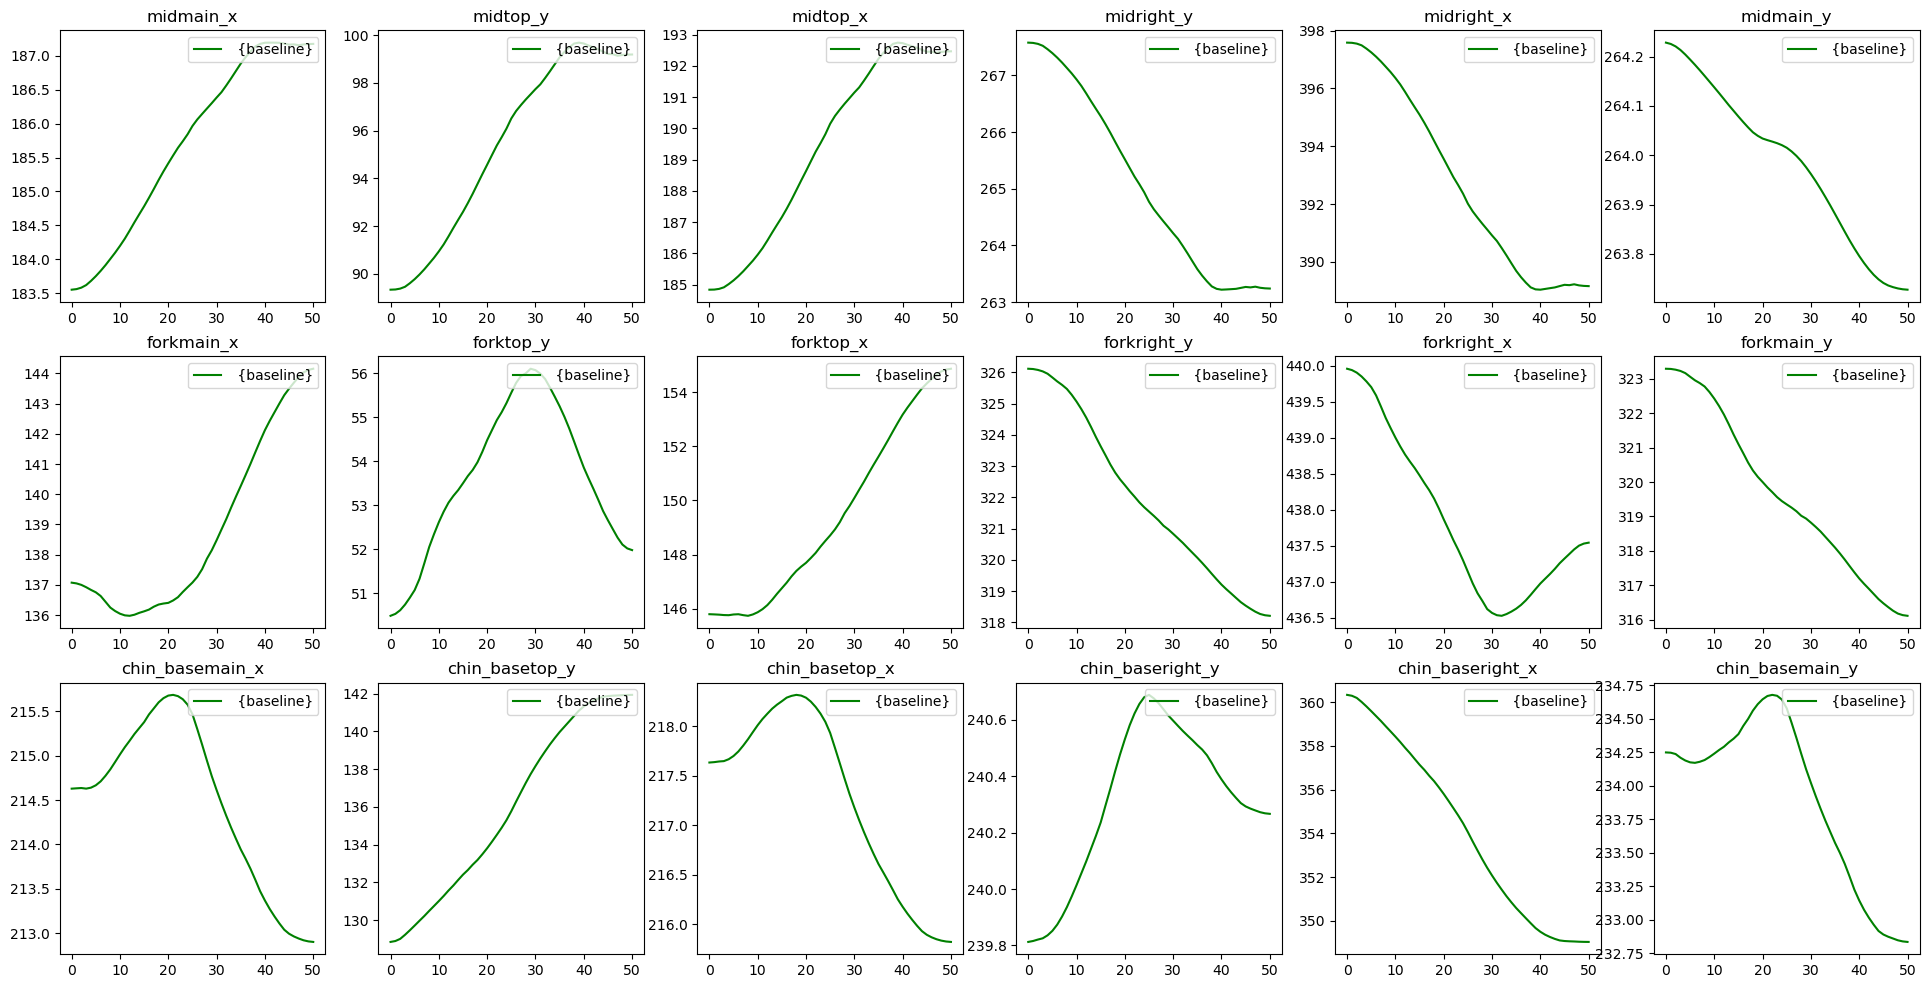

In [191]:
nkeys = len(keypoint_ensemble_list)
ncams = len(camkeys)
color = ['b','g','r','c','m','y','k']
fig,ax = plt.subplots(nkeys,2*ncams,figsize=(24,12))
for n,key in enumerate(keypoint_ensemble_list):
    for j,cam in enumerate(camkeys):
        #ax[n, 2*j].plot(all_mu[0]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["x"]- np.mean(all_mu[0]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["x"]) , color=color[0], label = ' {}'.format(mu[0]))
        #ax[n ,2*j].plot(pd.read_csv(file_path+"/network_0"+operator+name+".csv", header=[1,2])[key+'_'+cam][["x"]], color='gray', label = 'network 0')
        ax[n,2*j].title.set_text('{}'.format(key)+'{}'.format(cam)+'_x')
        ax[n, 2*j].plot(baseline[key+'_'+cam]["x"], color=color[1], label = ' {baseline}')
        ax[n,2*j].title.set_text('{}'.format(key)+'{}'.format(cam)+'_x')

        #ax[n, 2*j-1].plot(all_mu[0]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["y"]-np.mean(all_mu[0]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["y"]), color=color[0], label = ' {}'.format(mu[0]))
        ax[n, 2*j-1].plot(baseline[key+'_'+cam]["y"], color=color[1], label = ' {baseline}')
        #ax[n ,2*j-1].plot(pd.read_csv(file_path+"/network_0"+operator+name+".csv", header=[1,2])[key+'_'+cam][["y"]], color='gray', label='network 0')
        ax[n, 2*j-1].title.set_text('{}'.format(key)+'{}'.format(cam)+'_y')
        ax[n, 2*j].legend(loc='upper right')
        ax[n,2*j-1].legend(loc='upper right')

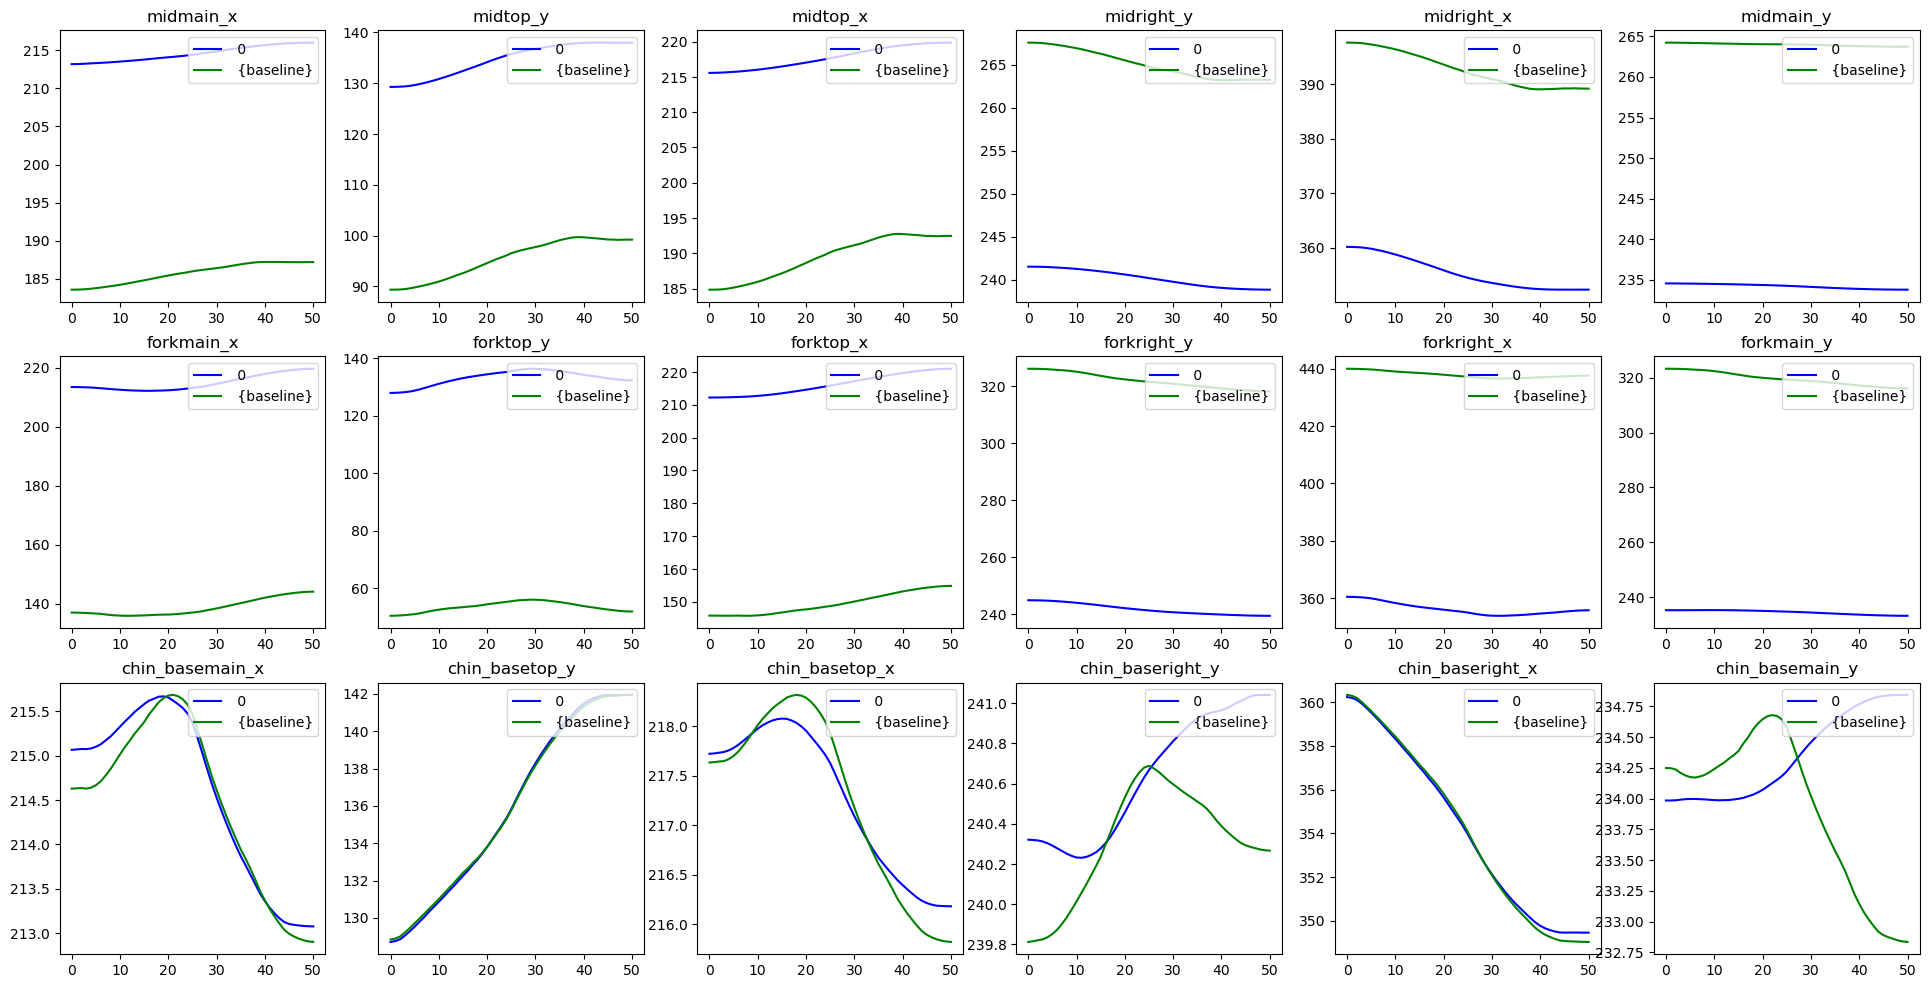

In [230]:
nkeys = len(keypoint_ensemble_list)
ncams = len(camkeys)
color = ['b','g','r','c','m','y','k']
fig,ax = plt.subplots(nkeys,2*ncams,figsize=(24,12))
for n,key in enumerate(keypoint_ensemble_list):
    for j,cam in enumerate(camkeys):
        ax[n, 2*j].plot(all_mu[0]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["x"] , color=color[0], label = ' {}'.format(mu[0]))
        #ax[n ,2*j].plot(pd.read_csv(file_path+"/network_0"+operator+name+".csv", header=[1,2])[key+'_'+cam][["x"]], color='gray', label = 'network 0')
        ax[n,2*j].title.set_text('{}'.format(key)+'{}'.format(cam)+'_x')
        ax[n, 2*j].plot(baseline[key+'_'+cam]["x"], color=color[1], label = ' {baseline}')
        ax[n,2*j].title.set_text('{}'.format(key)+'{}'.format(cam)+'_x')

        ax[n, 2*j-1].plot(all_mu[0]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["y"], color=color[0], label = ' {}'.format(mu[0]))
        ax[n, 2*j-1].plot(baseline[key+'_'+cam]["y"], color=color[1], label = ' {baseline}')
        #ax[n ,2*j-1].plot(pd.read_csv(file_path+"/network_0"+operator+name+".csv", header=[1,2])[key+'_'+cam][["y"]], color='gray', label='network 0')
        ax[n, 2*j-1].title.set_text('{}'.format(key)+'{}'.format(cam)+'_y')
        ax[n, 2*j].legend(loc='upper right')
        ax[n,2*j-1].legend(loc='upper right')

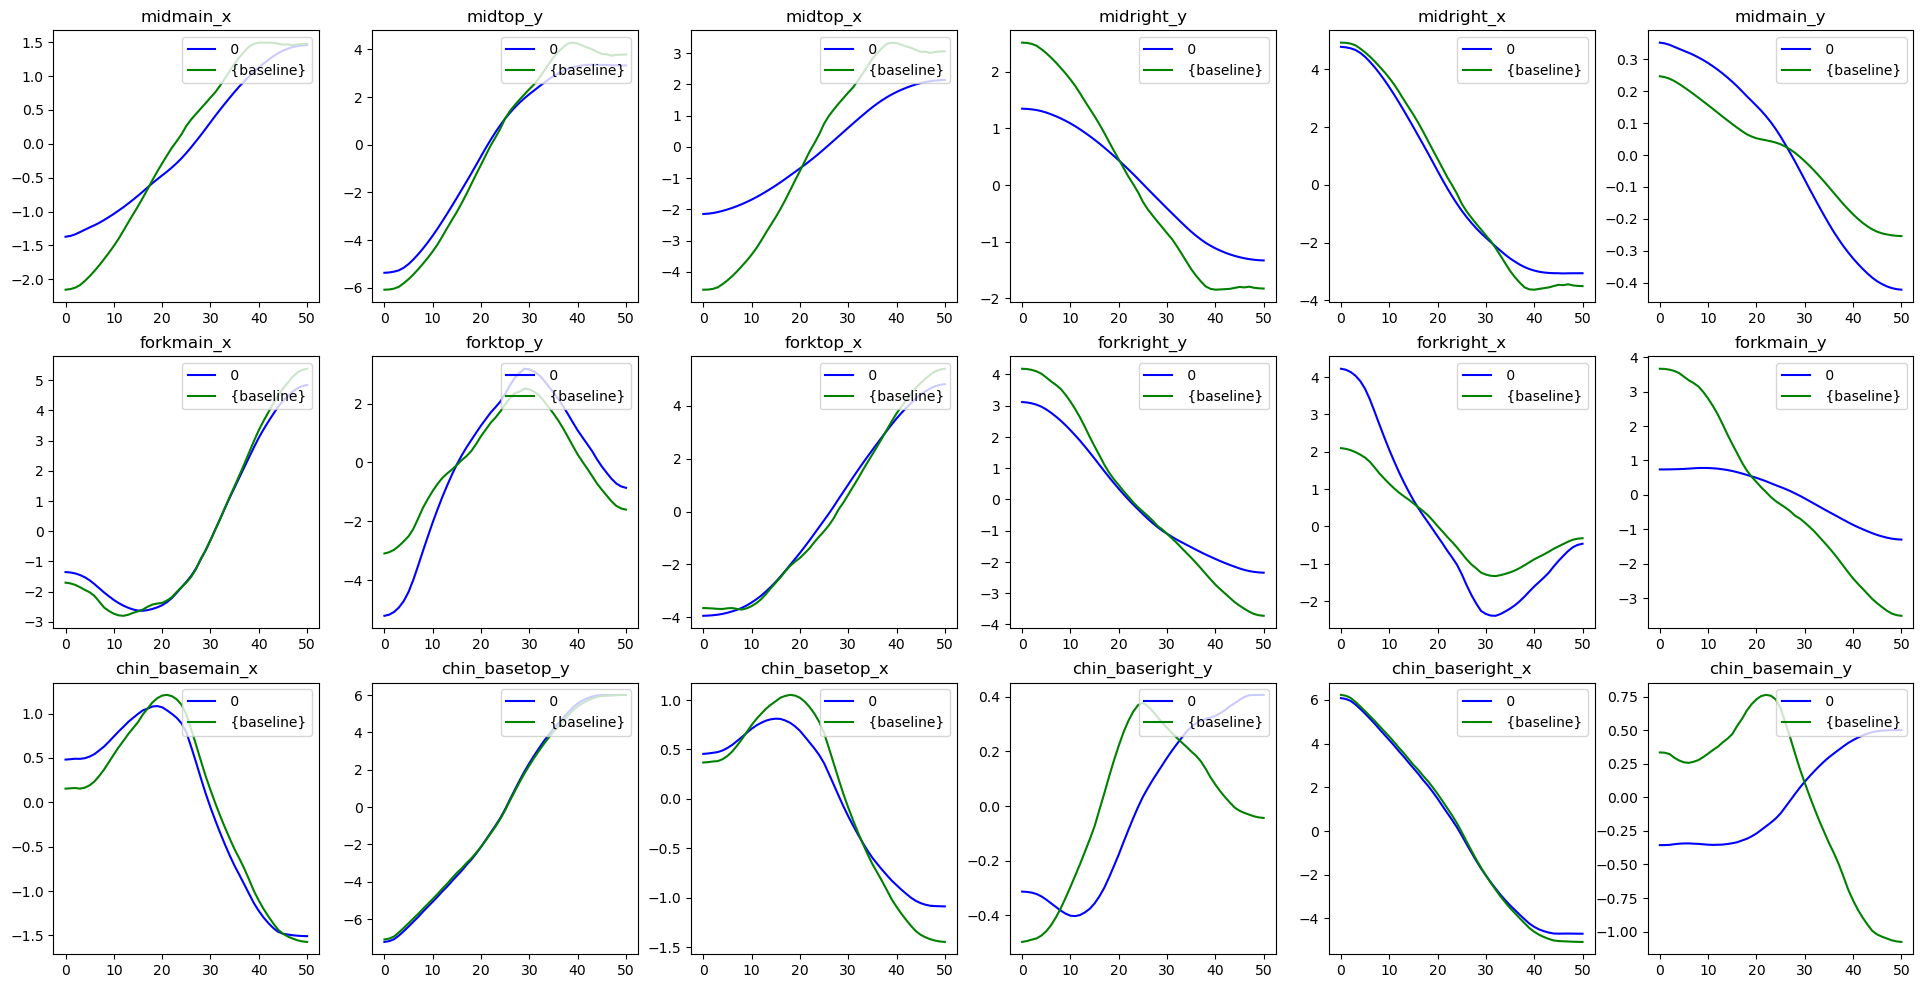

In [231]:
nkeys = len(keypoint_ensemble_list)
ncams = len(camkeys)
color = ['b','g','r','c','m','y','k']
fig,ax = plt.subplots(nkeys,2*ncams,figsize=(24,12))
for n,key in enumerate(keypoint_ensemble_list):
    for j,cam in enumerate(camkeys):
        ax[n, 2*j].plot(all_mu[0]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["x"]- np.mean(all_mu[0]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["x"]) , color=color[0], label = ' {}'.format(mu[0]))
        #ax[n ,2*j].plot(pd.read_csv(file_path+"/network_0"+operator+name+".csv", header=[1,2])[key+'_'+cam][["x"]], color='gray', label = 'network 0')
        ax[n,2*j].title.set_text('{}'.format(key)+'{}'.format(cam)+'_x')
        ax[n, 2*j].plot(baseline[key+'_'+cam]["x"]-np.mean(baseline[key+'_'+cam]["x"]), color=color[1], label = ' {baseline}')
        ax[n,2*j].title.set_text('{}'.format(key)+'{}'.format(cam)+'_x')

        ax[n, 2*j-1].plot(all_mu[0]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["y"]-np.mean(all_mu[0]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["y"]), color=color[0], label = ' {}'.format(mu[0]))
        ax[n, 2*j-1].plot(baseline[key+'_'+cam]["y"]- np.mean(baseline[key+'_'+cam]["y"]), color=color[1], label = ' {baseline}')
        #ax[n ,2*j-1].plot(pd.read_csv(file_path+"/network_0"+operator+name+".csv", header=[1,2])[key+'_'+cam][["y"]], color='gray', label='network 0')
        ax[n, 2*j-1].title.set_text('{}'.format(key)+'{}'.format(cam)+'_y')
        ax[n, 2*j].legend(loc='upper right')
        ax[n,2*j-1].legend(loc='upper right')
        

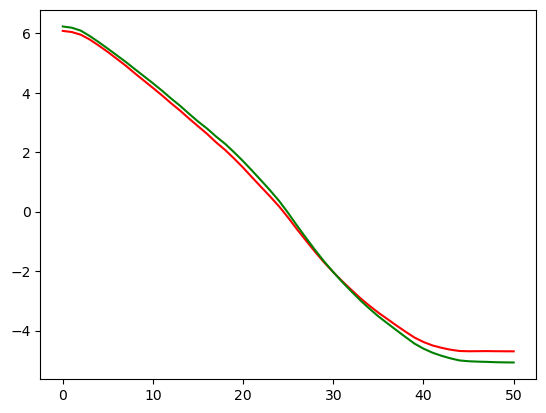

In [193]:
plt.plot(all_mu[0]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["x"] - np.mean(all_mu[0]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["x"]), color='r')
plt.plot(baseline[key+'_'+cam]["x"]- np.mean(baseline[key+'_'+cam]["x"]), color=color[1], label = ' {baseline}')

[('fork', 'mid'), ('chin_base', 'fork'), ('mid', 'chin_base')]

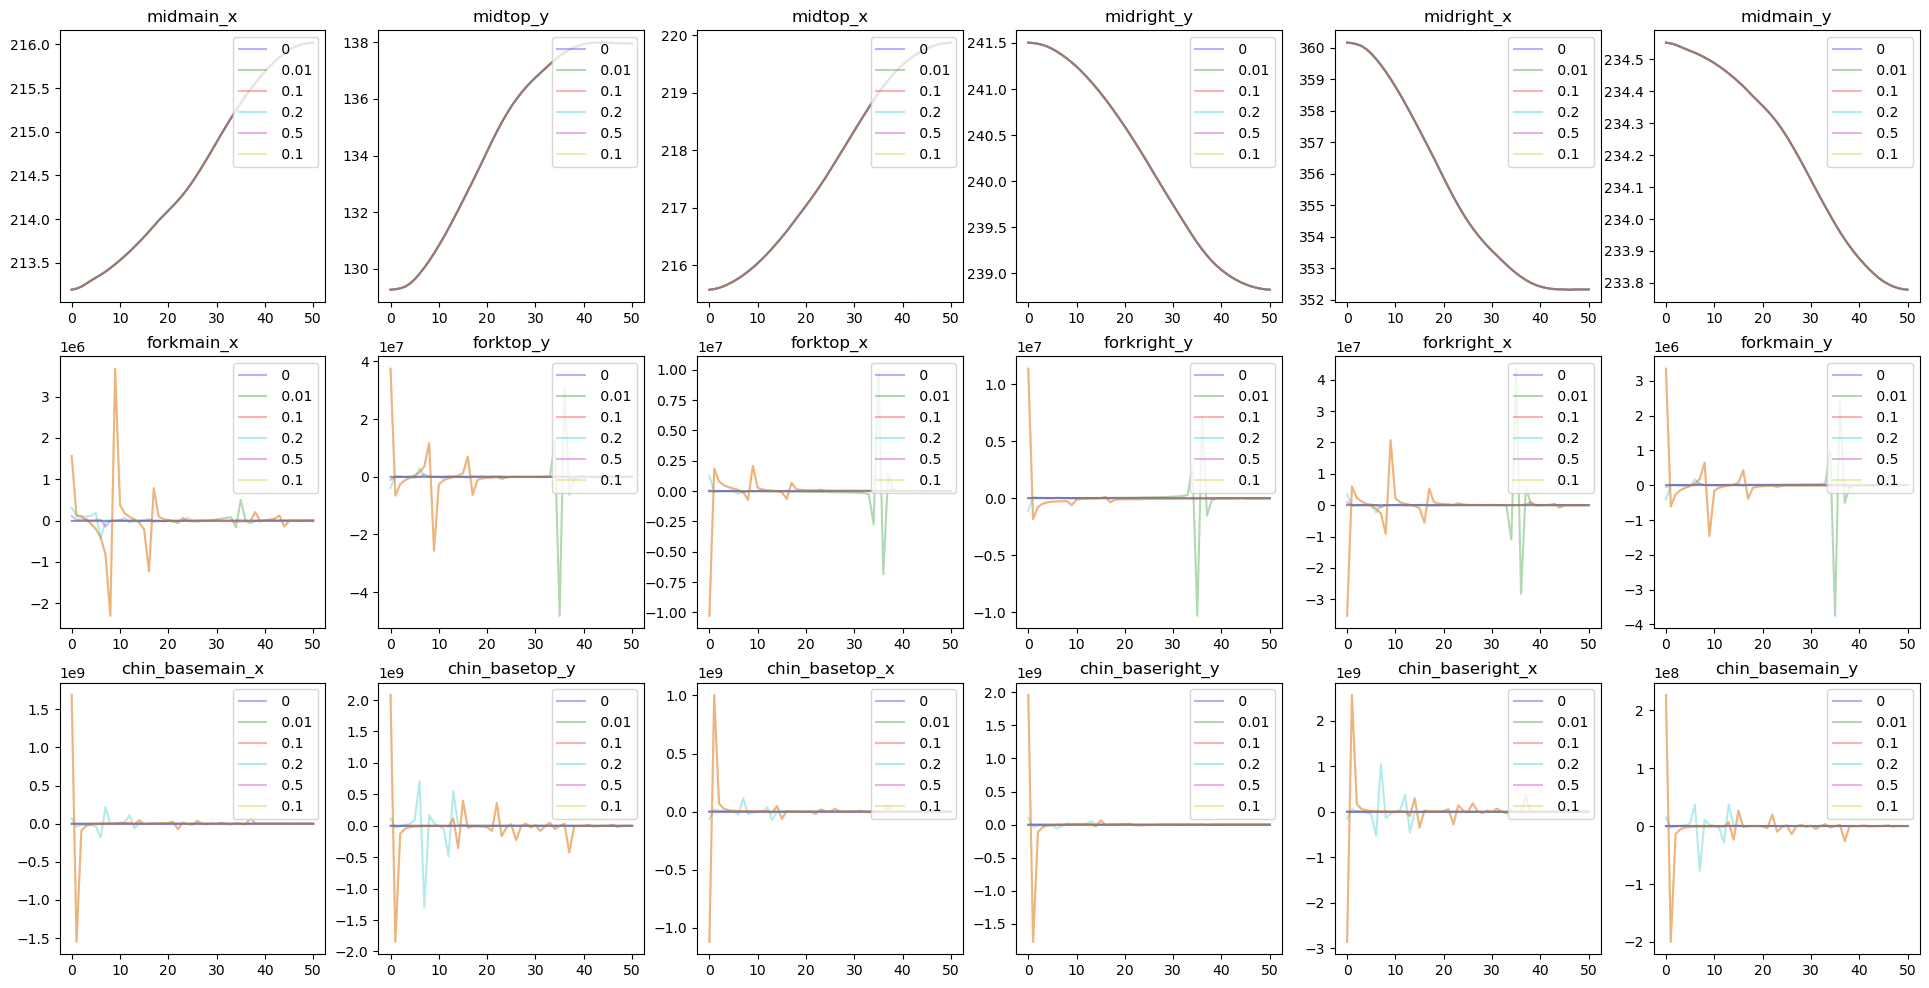

In [194]:
nkeys = len(keypoint_ensemble_list)
ncams = len(camkeys)
color = ['b','g','r','c','m','y','k']
fig,ax = plt.subplots(nkeys,2*ncams,figsize=(24,12))
for n,key in enumerate(keypoint_ensemble_list):
    for j,cam in enumerate(camkeys):
        for i in range(len(mu)):
            ax[n, 2*j].plot(all_mu[i]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["x"], color=color[i], label = ' {}'.format(mu[i]), alpha=0.3)
            ax[n,2*j].title.set_text('{}'.format(key)+'{}'.format(cam)+'_x')
            ax[n, 2*j-1].plot(all_mu[i]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["y"], color=color[i], label = ' {}'.format(mu[i]), alpha = 0.3)
            ax[n, 2*j-1].title.set_text('{}'.format(key)+'{}'.format(cam)+'_y')
            ax[n, 2*j].legend(loc='upper right')
            ax[n,2*j-1].legend(loc='upper right')
        

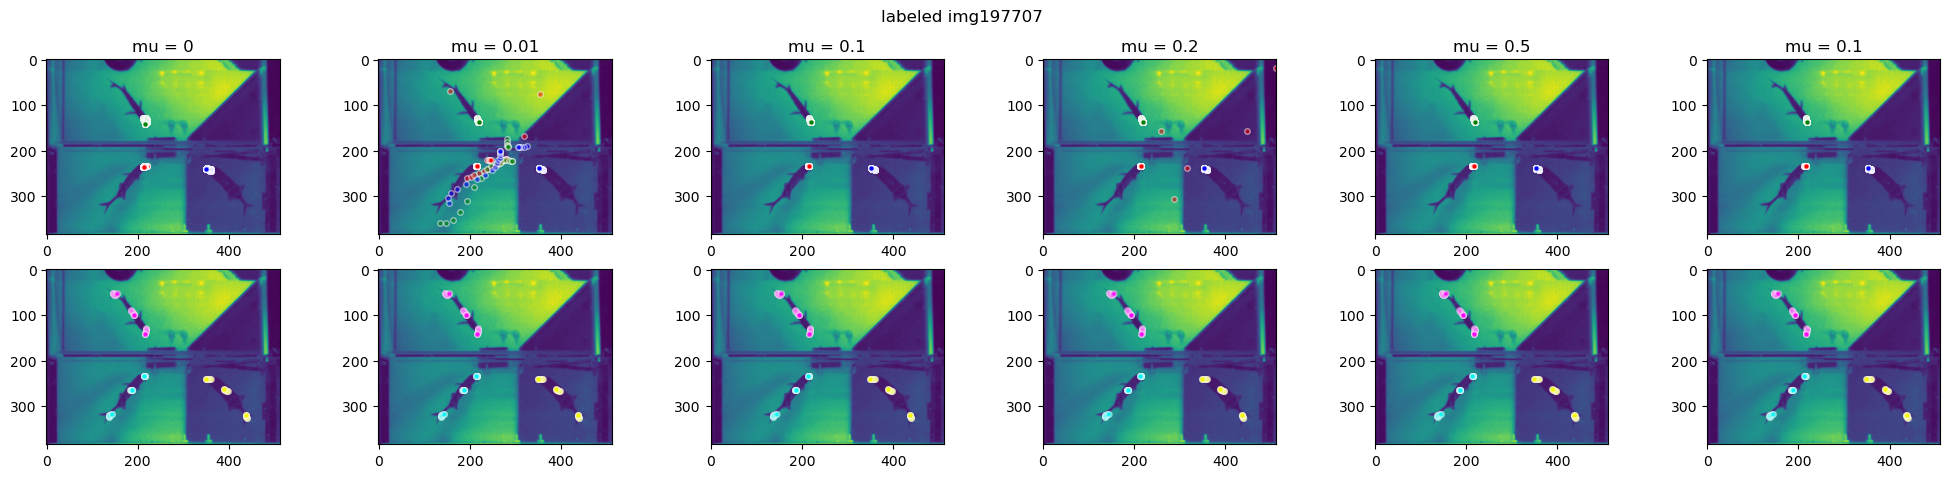

In [200]:
marker_shapes = 'o'
model_colors = ['red','green','blue']
colors2 = ['cyan','magenta','yellow']

fig,ax = plt.subplots(2,len(mu), figsize=(25,5))
for m in range(len(mu)):
    for j, key in enumerate(keypoint_ensemble_list):
        for i, cam in enumerate(camkeys):
            ax[0,m].plot(all_mu[m]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["x"], \
                      all_mu[m]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["y"]  , marker_shapes, markeredgecolor='w', markersize=4, 
                    color=model_colors[i], alpha=0.5)
            ax[0,m].title.set_text('mu = {}'.format(mu[m]))
            ax[1,m].plot(baseline[key+'_'+cam]["x"], \
                      baseline[key+'_'+cam]["y"]  , marker_shapes, markeredgecolor='w', markersize=4, 
                    color=colors2[i], alpha=0.1)

    image_path = "data/mirror-fish/labeled-data"
    im = plt.imread(image_path+operator+name+".png")
    ax[0,m].imshow(im)
    ax[1,m].imshow(im)
    plt.suptitle("labeled "+name)

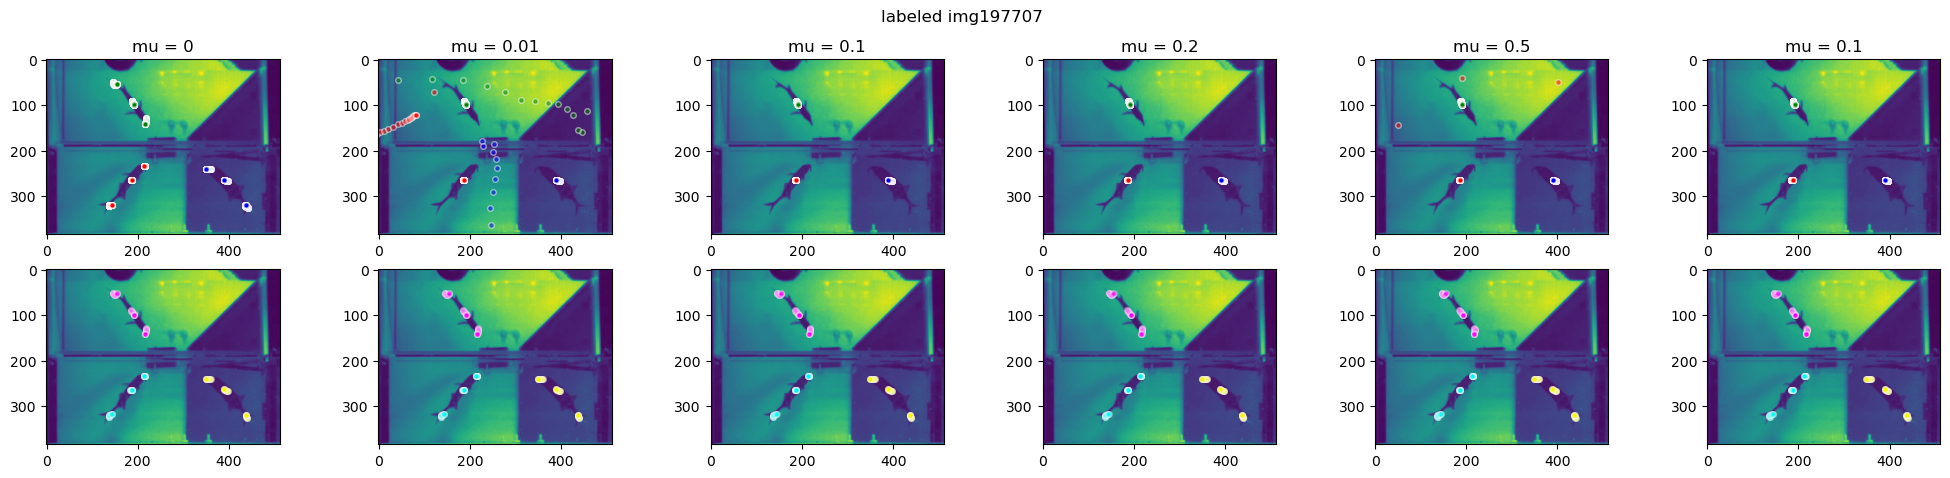

In [201]:
marker_shapes = 'o'
model_colors = ['red','green','blue']
colors2 = ['cyan','magenta','yellow']

fig,ax = plt.subplots(2,len(mu), figsize=(25,5))
for m in range(len(mu)):
    for j, key in enumerate(keypoint_ensemble_list):
        for i, cam in enumerate(camkeys):
            ax[0,m].plot(all_mu[m]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["x"]- np.mean(all_mu[m]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["x"])+np.mean(baseline[key+'_'+cam]["x"]), \
                      all_mu[m]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["y"]- np.mean(all_mu[m]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["y"])+np.mean(baseline[key+'_'+cam]["y"])  , marker_shapes, markeredgecolor='w', markersize=4, 
                    color=model_colors[i], alpha=0.5)
            ax[0,m].title.set_text('mu = {}'.format(mu[m]))
            ax[1,m].plot(baseline[key+'_'+cam]["x"], \
                      baseline[key+'_'+cam]["y"]  , marker_shapes, markeredgecolor='w', markersize=4, 
                    color=colors2[i], alpha=0.1)

    image_path = "data/mirror-fish/labeled-data"
    im = plt.imread(image_path+operator+name+".png")
    ax[0,m].imshow(im)
    ax[1,m].imshow(im)
    plt.suptitle("labeled "+name)

In [146]:
all_mu[0]['{}_df'.format(cam)]['ensemble-kalman_tracker']

bodyparts         mid                               fork              \
coords              x           y likelihood           x           y   
0          360.163407  241.503367        NaN  360.446817  244.912837   
1          360.147795  241.499150        NaN  360.421038  244.899748   
2          360.112485  241.490953        NaN  360.359799  244.871389   
3          360.055904  241.478699        NaN  360.260458  244.827524   
4          359.954727  241.459811        NaN  360.115427  244.764815   
5          359.816640  241.434512        NaN  359.906247  244.675980   
6          359.644498  241.403872        NaN  359.619578  244.569025   
7          359.453224  241.369249        NaN  359.283030  244.448880   
8          359.240933  241.331095        NaN  358.935694  244.316935   
9          359.011884  241.288943        NaN  358.598593  244.170262   
10         358.766787  241.242858        NaN  358.272555  244.011506   
11         358.510634  241.192501        NaN  357.969052  243.846122   
12         358.238459  241.137629        NaN  357.677993  243.673643   
13         357.959642  241.079462        NaN  357.410036  243.487675   
14         357.672753  241.018154        NaN  357.158476  243.297526   
15         357.379969  240.954201        NaN  356.924560  243.102800   
16         357.082975  240.887336        NaN  356.712568  242.902388   
17         356.786343  240.816795        NaN  356.516905  242.703784   
18         356.484617  240.743166        NaN  356.333762  242.509031   
19         356.175976  240.668148        NaN  356.145218  242.320317   
20         355.867232  240.591115        NaN  355.956103  242.137705   
21         355.562270  240.511980        NaN  355.770676  241.960937   
22         355.269471  240.430306        NaN  355.572103  241.793327   
23         354.991532  240.347131        NaN  355.391358  241.633263   
24         354.732612  240.261513        NaN  355.197552  241.479296   
25         354.489830  240.173643        NaN  354.942726  241.327157   
26         354.270378  240.086148        NaN  354.649752  241.178727   
27         354.069021  239.999320        NaN  354.384197  241.040850   
28         353.881437  239.913268        NaN  354.154236  240.915692   
29         353.710976  239.827317        NaN  353.956743  240.800507   
30         353.553038  239.741771        NaN  353.876392  240.698229   
31         353.404208  239.657873        NaN  353.833626  240.602885   
32         353.253189  239.573939        NaN  353.827197  240.512314   
33         353.107764  239.490705        NaN  353.874829  240.429031   
34         352.967716  239.409338        NaN  353.943599  240.348170   
35         352.838969  239.331556        NaN  354.020069  240.267469   
36         352.727496  239.259825        NaN  354.109377  240.187295   
37         352.625718  239.194084        NaN  354.217811  240.108694   
38         352.539195  239.133489        NaN  354.343260  240.033751   
39         352.470169  239.082602        NaN  354.480639  239.962552   
40         352.418010  239.037419        NaN  354.613540  239.892979   
41         352.378297  238.997482        NaN  354.731615  239.824690   
42         352.351157  238.961678        NaN  354.852316  239.761026   
43         352.335992  238.930405        NaN  354.979965  239.700763   
44         352.327937  238.903586        NaN  355.144089  239.643840   
45         352.325154  238.881003        NaN  355.295009  239.588595   
46         352.318308  238.861722        NaN  355.430859  239.541771   
47         352.323856  238.846959        NaN  355.560744  239.505219   
48         352.324783  238.835003        NaN  355.665094  239.479303   
49         352.325162  238.827083        NaN  355.728144  239.461768   
50         352.325283  238.823138        NaN  355.757793  239.452927   

bodyparts              chin_base                         
coords    likelihood           x           y likelihood  
0                NaN  360.234134  240.320633        NaN  
1        

In [103]:
## REGULAR EKS
for keypoint_ensemble in keypoint_ensemble_list:
    num_cameras = len(camera_names)
    markers_list_stacked_interp = []
    markers_list_interp = [[] for i in range(num_cameras)]
    for model_id in range(len(markers_list_cameras[0])):
        bl_markers_curr = []
        camera_markers_curr = [[] for i in range(num_cameras)]
        for i in range(markers_list_cameras[0][0].shape[0]):
            curr_markers = []
            for camera in range(num_cameras):
                markers = np.array(markers_list_cameras[camera][model_id].to_numpy()[i, [0, 1]])
                camera_markers_curr[camera].append(markers)
                curr_markers.append(markers)
            bl_markers_curr.append(np.concatenate(curr_markers)) #combine predictions for both cameras
        markers_list_stacked_interp.append(bl_markers_curr)
        for camera in range(num_cameras):
            markers_list_interp[camera].append(camera_markers_curr[camera])
    markers_list_stacked_interp = np.asarray(markers_list_stacked_interp)
    markers_list_interp = np.asarray(markers_list_interp)

    keys = [keypoint_ensemble+'_x', keypoint_ensemble+'_y']
    markers_list_cams = [[] for i in range(num_cameras)]
    for k in range(len(markers_list_interp[0])):
        for camera in range(num_cameras):
            markers_cam = pd.DataFrame(markers_list_interp[camera][k], columns = keys)
            markers_list_cams[camera].append(markers_cam)

    #compute ensemble median for each camera
    cam_ensemble_preds = []
    cam_ensemble_vars = []
    cam_ensemble_stacks = []
    cam_keypoints_mean_dict = []
    cam_keypoints_var_dict = []
    cam_keypoints_stack_dict = []
    for camera in range(num_cameras):
        cam_ensemble_preds_curr, cam_ensemble_vars_curr, cam_ensemble_stacks_curr, cam_keypoints_mean_dict_curr, cam_keypoints_var_dict_curr, cam_keypoints_stack_dict_curr = ensemble(markers_list_cams[camera], keys)
        cam_ensemble_preds.append(cam_ensemble_preds_curr)
        cam_ensemble_vars.append(cam_ensemble_vars_curr)
        cam_ensemble_stacks.append(cam_ensemble_stacks_curr)
        cam_keypoints_mean_dict.append(cam_keypoints_mean_dict_curr)
        cam_keypoints_var_dict.append(cam_keypoints_var_dict_curr)
        cam_keypoints_stack_dict.append(cam_keypoints_stack_dict_curr)

    #filter by low ensemble variances
    hstacked_vars = np.hstack(cam_ensemble_vars)
    max_vars = np.max(hstacked_vars,1)
    quantile_keep = quantile_keep_pca
    good_frames = np.where(max_vars <= np.percentile(max_vars, quantile_keep))[0]

    good_cam_ensemble_preds = []
    good_cam_ensemble_vars = []
    for camera in range(num_cameras):
        good_cam_ensemble_preds.append(cam_ensemble_preds[camera][good_frames])
        good_cam_ensemble_vars.append(cam_ensemble_vars[camera][good_frames])

    good_ensemble_preds = np.hstack(good_cam_ensemble_preds)
    good_ensemble_vars = np.hstack(good_cam_ensemble_vars)
    means_camera = []
    for i in range(good_ensemble_preds.shape[1]):
        means_camera.append(good_ensemble_preds[:,i].mean())

    ensemble_preds = np.hstack(cam_ensemble_preds)
    ensemble_vars = np.hstack(cam_ensemble_vars)
    ensemble_stacks = np.concatenate(cam_ensemble_stacks,2)
    scaled_ensemble_stacks = remove_camera_means(ensemble_stacks, means_camera)

    good_scaled_ensemble_preds = remove_camera_means(good_ensemble_preds[None,:,:], means_camera)[0]
    ## PCA 
    ensemble_pca, ensemble_ex_var = pca(good_scaled_ensemble_preds, 3)

    scaled_ensemble_preds = remove_camera_means(ensemble_preds[None,:,:], means_camera)[0]
    ensemble_pcs = ensemble_pca.transform(scaled_ensemble_preds)
    good_ensemble_pcs = ensemble_pcs[good_frames]
 
    y_obs = scaled_ensemble_preds
    # print("input",y_obs.shape)
    
    #compute center of mass
    #latent variables (observed)

    good_z_t_obs = good_ensemble_pcs #latent variables - true 3D pca


    ##### Set values for kalman filter #####
    m0 = np.asarray([0.0, 0.0, 0.0]) # initial state: mean
    S0 =  np.asarray([[np.var(good_z_t_obs[:,0]), 0.0, 0.0], [0.0, np.var(good_z_t_obs[:,1]), 0.0], [0.0, 0.0, np.var(good_z_t_obs[:,2])]]) # diagonal: var

    A = np.asarray([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]) #state-transition matrix,
    # Q = np.asarray([[10.0, 0.0, 0.0], [0.0, 10.0, 0.0], [0.0, 0.0, 10.0]]) #state covariance matrix?????
    d_t = good_z_t_obs[1:] - good_z_t_obs[:-1]

    Q = smooth_param*np.cov(d_t.T)

    C = ensemble_pca.components_.T # Measurement function is inverse transform of PCA
    R = np.eye(ensemble_pca.components_.shape[1]) # placeholder diagonal matrix for ensemble variance


    print(f"filtering {keypoint_ensemble}...")
    mf, Vf, S = filtering_pass(y_obs, m0, S0, C, R, A, Q, ensemble_vars)
    print(S.shape)
    print("done filtering")
    y_m_filt = np.dot(C, mf.T).T
    y_v_filt = np.swapaxes(np.dot(C, np.dot(Vf, C.T)), 0, 1)

    # Do the smoothing step
    print(f"smoothing {keypoint_ensemble}...")
    ms, Vs, _ = smooth_backward(y_obs, mf, Vf, S, A, Q, C)
    print("done smoothing")

    # Smoothed posterior over y
    y_m_smooth2 = np.dot(C, ms.T).T
    y_v_smooth2 = np.swapaxes(np.dot(C, np.dot(Vs, C.T)), 0, 1)

    

filtering mid...
(51, 3, 3)
done filtering
smoothing mid...
done smoothing
filtering fork...
(51, 3, 3)
done filtering
smoothing fork...
done smoothing
filtering chin_base...
(51, 3, 3)
done filtering
smoothing chin_base...
done smoothing


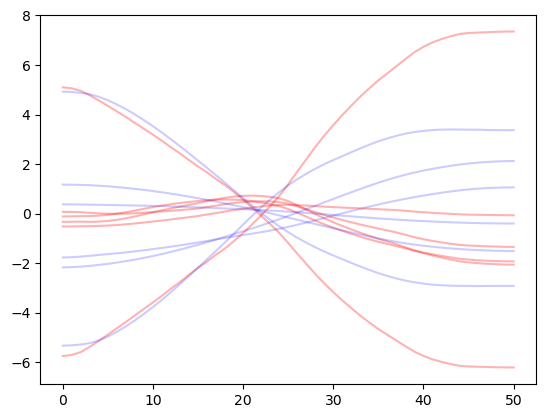

In [145]:

for i in range(6):
    plt.plot(y_m_smooth2[:,i], color='r', alpha=0.3)
    plt.plot(y_m_smooth[0][:,i], alpha=0.2, color='b')

In [109]:
keypoint_ensemble_list

['mid', 'fork', 'chin_base']

In [113]:
y_m_smooth[0].shape

(51, 6)